In [97]:
# !pip install pandas matplotlib numpy scipy seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
import seaborn as sns

In [98]:


# Load the merged_all_predictions_2023.csv file into a pandas DataFrame
df_predictions = pd.read_csv('ML_Data/merged_all_predictions_2023.csv')

# Convert the 'timestamp' column to datetime objects
# This allows for time-based indexing and operations.
df_predictions['timestamp'] = pd.to_datetime(df_predictions['timestamp'])

# Set the 'timestamp' column as the DataFrame's index
# This is crucial for time-series analysis in pandas.
df_predictions = df_predictions.set_index('timestamp')

# Display the first few rows of the preprocessed DataFrame to confirm correct loading
print("First 5 rows of the DataFrame after preprocessing:")
print(df_predictions.head())

# Display a summary of the DataFrame including data types and non-null values
print("\nDataFrame Information:")
print(df_predictions.info())

First 5 rows of the DataFrame after preprocessing:
                        lstm_pred         ERCOT  transformer_pred  \
timestamp                                                           
2023-01-01 01:00:00  35083.950304  35609.173887      34703.830753   
2023-01-01 02:00:00  35617.214363  35012.298856      34530.598541   
2023-01-01 03:00:00  35721.843124  34369.582295      34052.180130   
2023-01-01 04:00:00  35149.047775  34000.730337      33399.715560   
2023-01-01 05:00:00  35371.010962  33865.078669      33548.010235   

                     linear_regression_pred  
timestamp                                    
2023-01-01 01:00:00            43231.574553  
2023-01-01 02:00:00            41220.267288  
2023-01-01 03:00:00            41345.789245  
2023-01-01 04:00:00            44472.861881  
2023-01-01 05:00:00            42824.906094  

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9492 entries, 2023-01-01 01:00:00 to 2023-12-31 23:00:00
Data colu

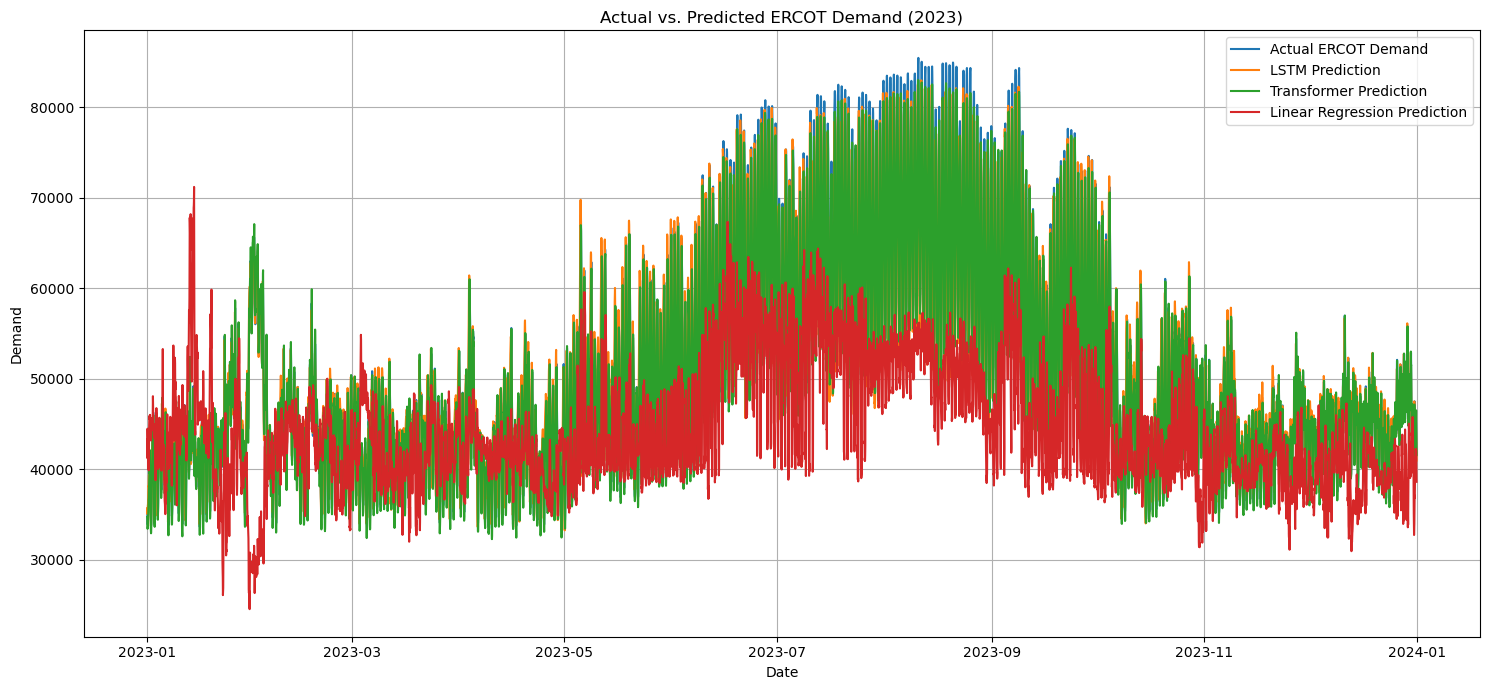

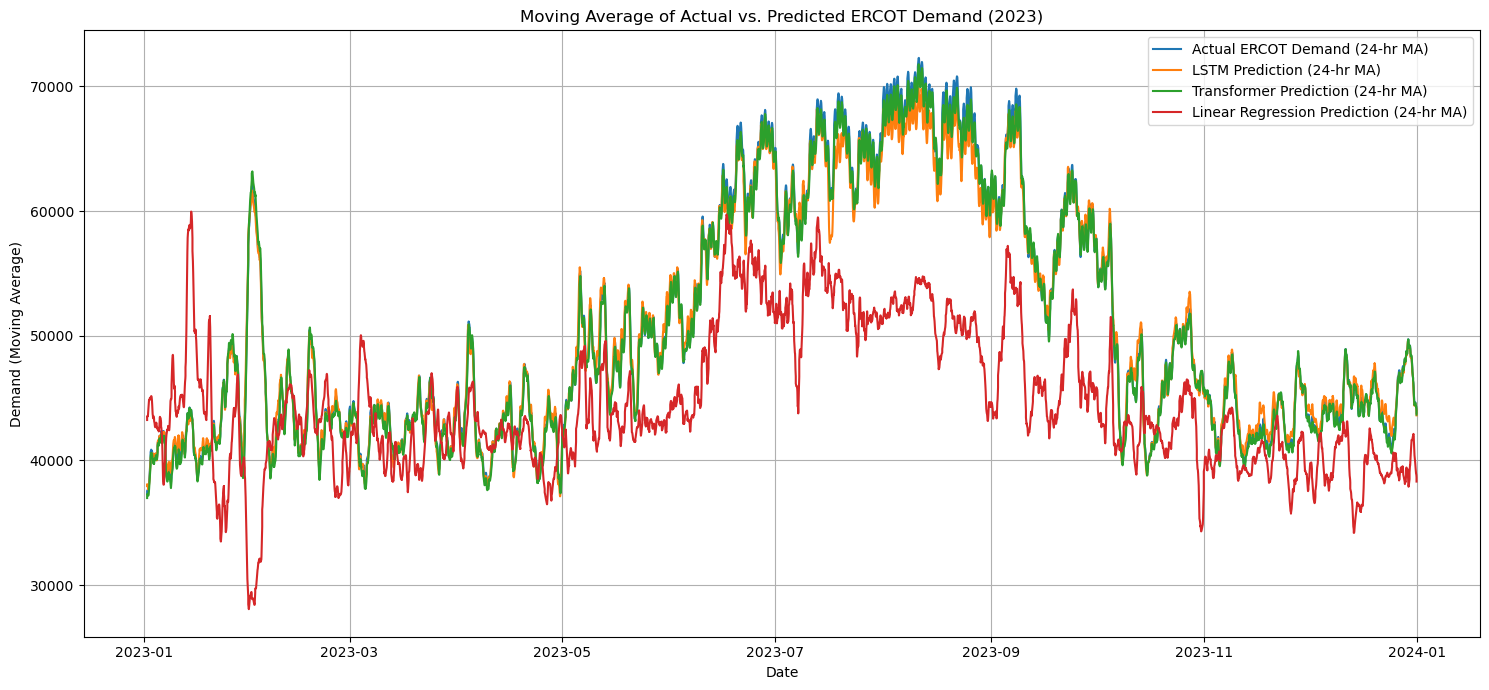

In [99]:
# 1. Trend Analysis

# --- Plot 1: Raw Actual vs. Predicted ERCOT Demand ---
plt.figure(figsize=(15, 7)) # Set the figure size for better readability
plt.plot(df_predictions['ERCOT'], label='Actual ERCOT Demand') # Plot actual demand
plt.plot(df_predictions['lstm_pred'], label='LSTM Prediction') # Plot LSTM model predictions
plt.plot(df_predictions['transformer_pred'], label='Transformer Prediction') # Plot Transformer model predictions
plt.plot(df_predictions['linear_regression_pred'], label='Linear Regression Prediction') # Plot Linear Regression model predictions

plt.title('Actual vs. Predicted ERCOT Demand (2023)') # Set the plot title
plt.xlabel('Date') # Label for the x-axis
plt.ylabel('Demand') # Label for the y-axis
plt.legend() # Display legend to differentiate lines
plt.grid(True) # Add a grid for easier reading
plt.tight_layout() # Adjust plot parameters for a tight layout
plt.savefig('actual_vs_predicted_demand.png') # Save the plot as a PNG file
plt.show() # Display the plot

# --- Plot 2: Moving Average of Actual vs. Predicted ERCOT Demand ---
# Calculate 24-hour rolling mean (moving average) for each demand series.
# A 24-hour window smooths out daily fluctuations, revealing longer-term trends.
df_predictions['ERCOT_MA'] = df_predictions['ERCOT'].rolling(window=24).mean()
df_predictions['lstm_pred_MA'] = df_predictions['lstm_pred'].rolling(window=24).mean()
df_predictions['transformer_pred_MA'] = df_predictions['transformer_pred'].rolling(window=24).mean()
df_predictions['linear_regression_pred_MA'] = df_predictions['linear_regression_pred'].rolling(window=24).mean()

plt.figure(figsize=(15, 7)) # Set the figure size
plt.plot(df_predictions['ERCOT_MA'], label='Actual ERCOT Demand (24-hr MA)')
plt.plot(df_predictions['lstm_pred_MA'], label='LSTM Prediction (24-hr MA)')
plt.plot(df_predictions['transformer_pred_MA'], label='Transformer Prediction (24-hr MA)')
plt.plot(df_predictions['linear_regression_pred_MA'], label='Linear Regression Prediction (24-hr MA)')

plt.title('Moving Average of Actual vs. Predicted ERCOT Demand (2023)') # Set the plot title
plt.xlabel('Date') # Label for the x-axis
plt.ylabel('Demand (Moving Average)') # Label for the y-axis
plt.legend() # Display legend
plt.grid(True) # Add grid
plt.tight_layout() # Adjust layout
plt.savefig('moving_average_demand.png') # Save the plot
plt.show() # Display the plot

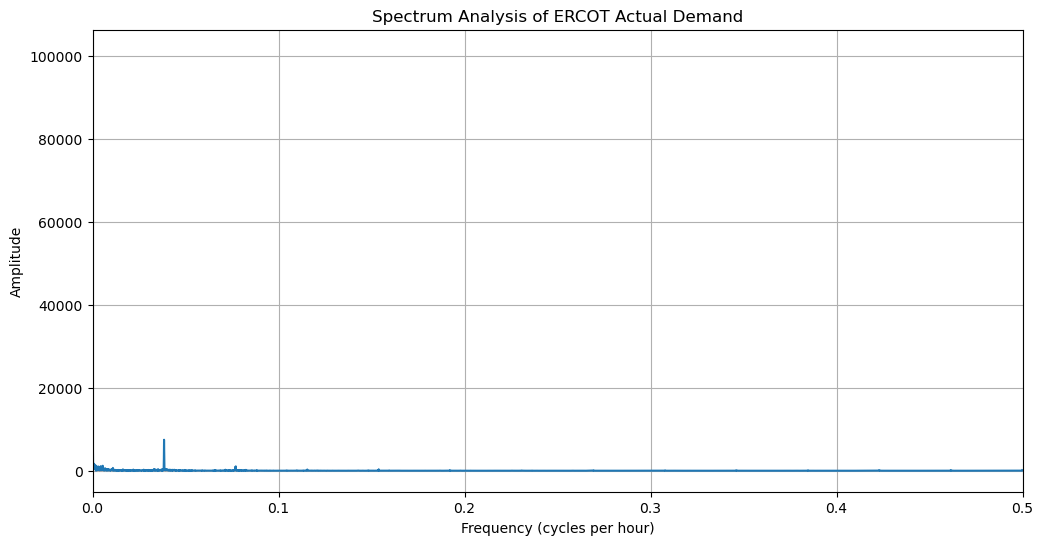


Dominant Periods (in hours): [          inf 9492.           26.00547945 4746.           25.93442623]


C:\Users\sajib\AppData\Local\Temp\ipykernel_28644\2749550584.py:38: RuntimeWarning: divide by zero encountered in divide
  dominant_periods = 1 / dominant_frequencies


In [100]:
# 2. Spectrum Analysis on ERCOT actual demand

# Drop any NaN values from the 'ERCOT' demand series before performing FFT.
# FFT requires a continuous, non-missing data series.
demand_series = df_predictions['ERCOT'].dropna()

N = len(demand_series) # Number of data points in the demand series
T = 1.0  # Sample spacing, which is 1 hour since data is hourly

# Perform the Fast Fourier Transform (FFT) on the demand data.
# The FFT transforms the signal from the time domain to the frequency domain.
yf = fft(demand_series.values)

# Calculate the frequencies corresponding to the FFT results.
# We only care about the positive frequencies, up to N//2.
xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(12, 6)) # Set the figure size
# Plot the amplitude (magnitude) of the FFT results against their frequencies.
# We multiply by 2.0/N to normalize the amplitudes.
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

plt.title('Spectrum Analysis of ERCOT Actual Demand') # Set the plot title
plt.xlabel('Frequency (cycles per hour)') # Label for the x-axis
plt.ylabel('Amplitude') # Label for the y-axis
plt.grid(True) # Add grid
plt.xlim(0, 0.5) # Limit x-axis to relevant frequencies (Nyquist frequency is 0.5 cycles/hour for hourly data)
plt.savefig('spectrum_analysis.png') # Save the plot
plt.show() # Display the plot

# Identify dominant periods by finding the frequencies with the highest amplitudes.
# Sort indices by amplitude in descending order
idx = np.argsort(2.0/N * np.abs(yf[0:N//2]))[::-1]
dominant_frequencies = xf[idx[:5]] # Get the top 5 dominant frequencies

# Convert dominant frequencies into periods (Period = 1 / Frequency)
# Note: Frequencies close to 0 might result in very large periods (inf), representing overall trend.
dominant_periods = 1 / dominant_frequencies
print("\nDominant Periods (in hours):", dominant_periods)

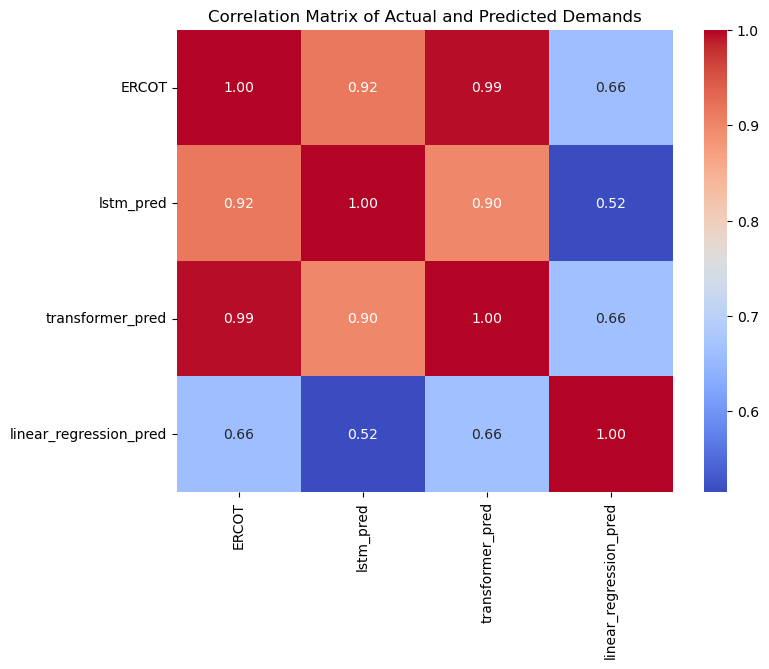


DataFrame with moving averages saved to 'predictions_with_moving_averages.csv'.


In [101]:
# 3. Correlation

# Calculate the Pearson correlation matrix for the actual ERCOT demand
# and the predictions from the LSTM, Transformer, and Linear Regression models.
correlation_matrix = df_predictions[['ERCOT', 'lstm_pred', 'transformer_pred', 'linear_regression_pred']].corr()

plt.figure(figsize=(8, 6)) # Set the figure size for the heatmap
# Create a heatmap to visualize the correlation matrix.
# `annot=True` displays the correlation values on the heatmap.
# `cmap='coolwarm'` sets the color scheme, where warm colors (red) indicate positive correlation
# and cool colors (blue) indicate negative correlation.
# `fmt=".2f"` formats the annotations to two decimal places.
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix of Actual and Predicted Demands') # Set the plot title
plt.savefig('correlation_matrix.png') # Save the plot
plt.show() # Display the plot

# Save the DataFrame with calculated moving averages to a new CSV file.
# This file will contain all original data plus the 24-hour moving averages.
df_predictions.to_csv('predictions_with_moving_averages.csv')
print("\nDataFrame with moving averages saved to 'predictions_with_moving_averages.csv'.")

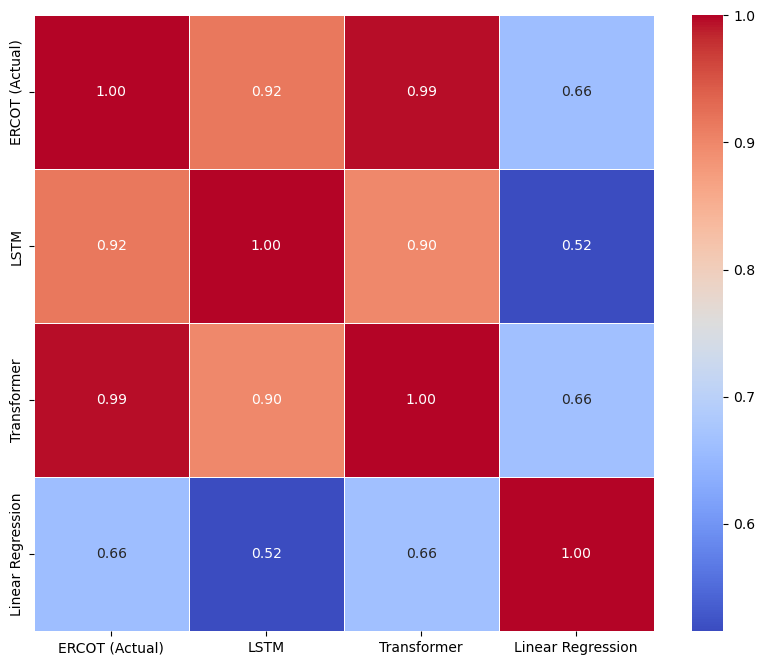

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged_all_predictions_2023.csv file
df_predictions = pd.read_csv('ML_Data/merged_all_predictions_2023.csv')

# Convert 'timestamp' to datetime and set as index
df_predictions['timestamp'] = pd.to_datetime(df_predictions['timestamp'])
df_predictions = df_predictions.set_index('timestamp')

# Rename the columns for better readability in the correlation matrix
df_predictions_renamed = df_predictions.rename(columns={
    'ERCOT': 'ERCOT (Actual)',
    'lstm_pred': 'LSTM',
    'transformer_pred': 'Transformer',
    'linear_regression_pred': 'Linear Regression'
})

# Select only the relevant columns for correlation analysis with new names
correlation_data = df_predictions_renamed[[
    'ERCOT (Actual)',
    'LSTM',
    'Transformer',
    'Linear Regression'
]]

# Calculate the correlation matrix with the renamed columns
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8)) # Increased figure size for better label visibility
# Create a heatmap with the updated correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# plt.title('Correlation Matrix of Actual and Predicted Demands (Renamed Labels)')
# plt.savefig('correlation_matrix_renamed.png') # Save the plot with a new file name
plt.show()

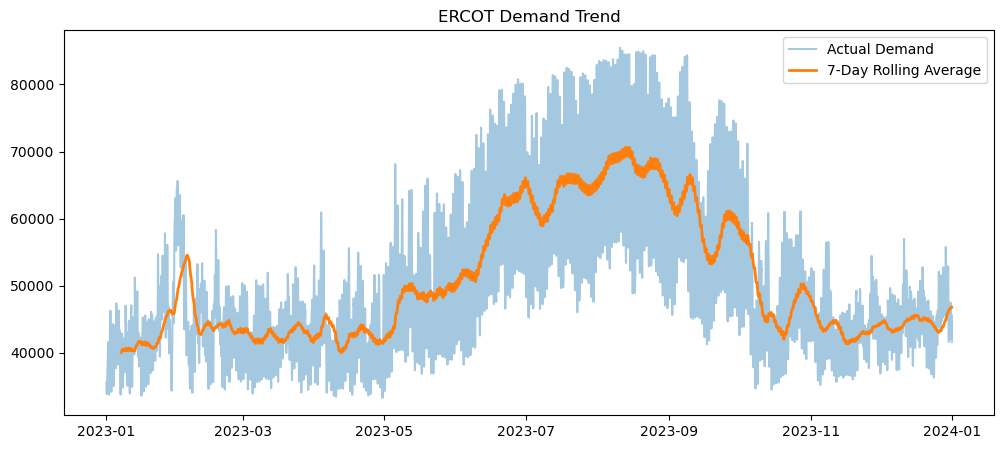

In [103]:
import matplotlib.pyplot as plt

# Plot actual demand with rolling average (weekly)
df_predictions['ERCOT_rolling'] = df_predictions['ERCOT'].rolling(window=24*7).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_predictions['ERCOT'], label='Actual Demand', alpha=0.4)
plt.plot(df_predictions['ERCOT_rolling'], label='7-Day Rolling Average', linewidth=2)
plt.title('ERCOT Demand Trend')
plt.legend()
plt.show()


In [104]:
# Seasonal Decomposition Plot

In [135]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# decomp = seasonal_decompose(df_predictions['ERCOT'], model='additive', period=24*7)
# decomp.plot()
# plt.show()


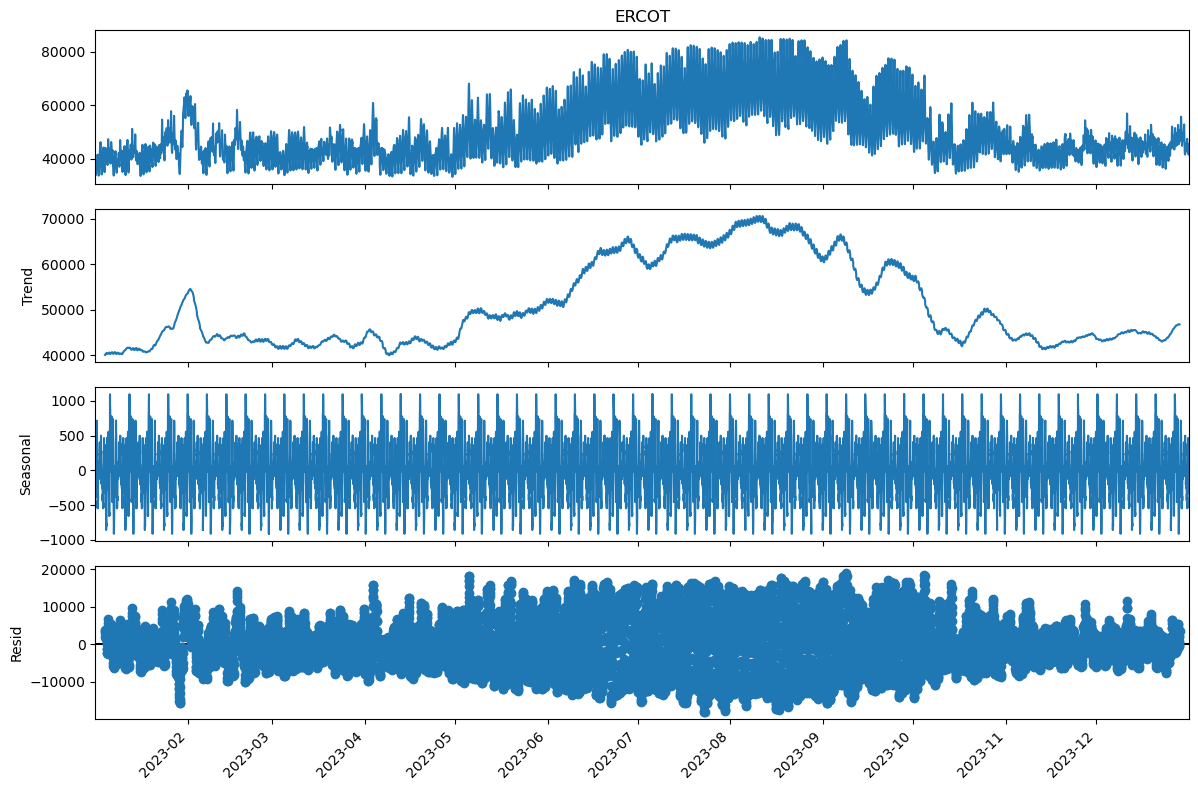

In [106]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform decomposition
decomp = seasonal_decompose(df_predictions['ERCOT'], model='additive', period=24*7)

# Plot with clear x-axis formatting
fig = decomp.plot()
fig.set_size_inches(12, 8)

# Rotate x-axis labels for all subplots
for ax in fig.axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()


## Spectrum (Frequency) Analysis

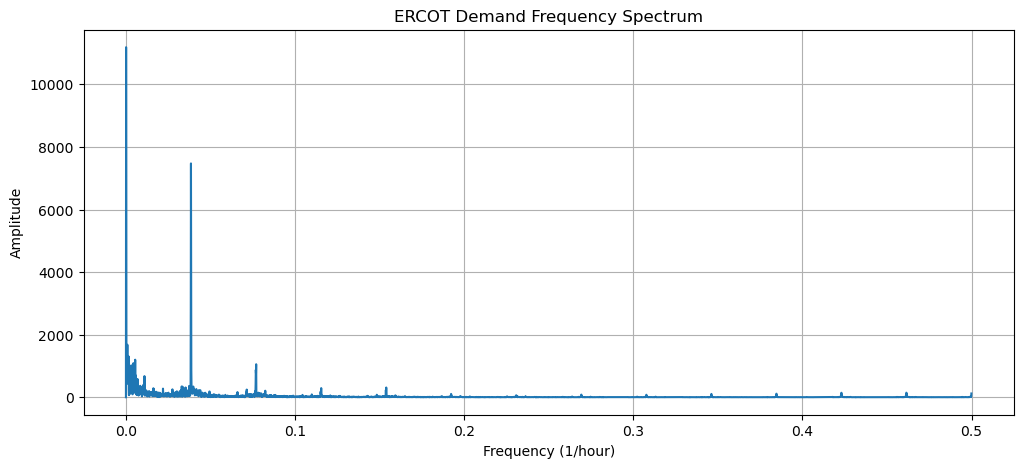

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# Remove mean to detrend
ercot_detrended = df_predictions['ERCOT'] - df_predictions['ERCOT'].mean()

# Convert to NumPy array before FFT
ercot_array = ercot_detrended.to_numpy()

# Perform FFT
N = len(ercot_array)
T = 1  # 1 hour sampling interval
yf = fft(ercot_array)
xf = np.fft.fftfreq(N, T)[:N//2]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title('ERCOT Demand Frequency Spectrum')
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


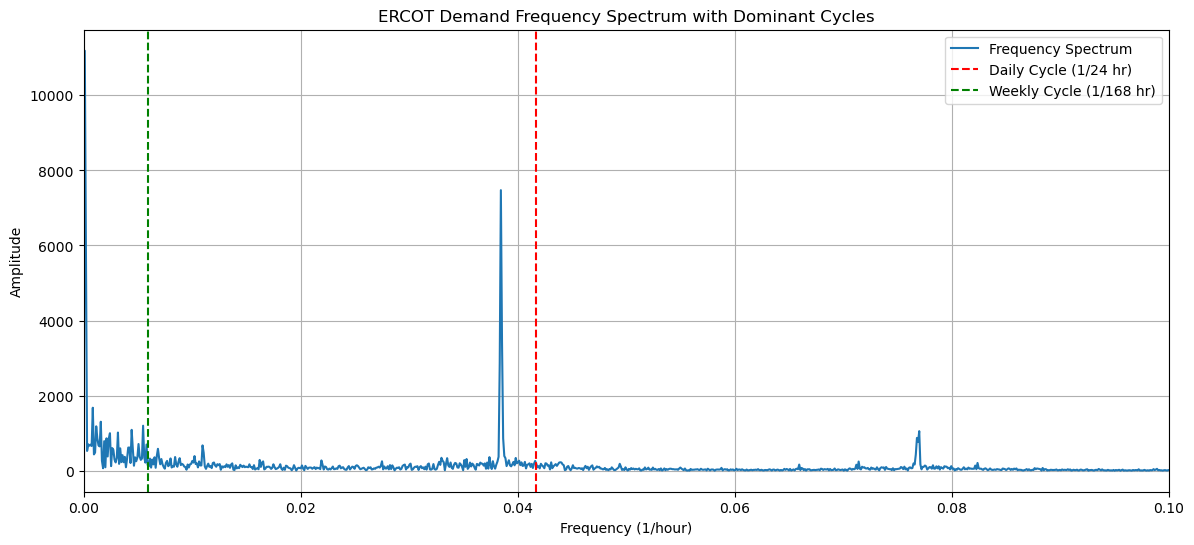

In [137]:
# Updated Fast Fourier Transform (FFT) Code with Daily & Weekly Frequency Highlights
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# Detrend and convert to NumPy array
ercot_detrended = df_predictions['ERCOT'] - df_predictions['ERCOT'].mean()
ercot_array = ercot_detrended.to_numpy()

# FFT
N = len(ercot_array)
T = 1  # hourly data
yf = fft(ercot_array)
xf = np.fft.fftfreq(N, T)[:N//2]
amplitudes = 2.0/N * np.abs(yf[:N//2])

# Plot
plt.figure(figsize=(14, 6))
plt.plot(xf, amplitudes, label='Frequency Spectrum')

# Highlight dominant cycles
daily_freq = 1 / 24       # 1 cycle per 24 hours
weekly_freq = 1 / (24*7)  # 1 cycle per 168 hours

plt.axvline(daily_freq, color='r', linestyle='--', label='Daily Cycle (1/24 hr)')
plt.axvline(weekly_freq, color='g', linestyle='--', label='Weekly Cycle (1/168 hr)')

plt.title('ERCOT Demand Frequency Spectrum with Dominant Cycles')
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)  # Zoom in on low frequencies for better visibility
plt.show()


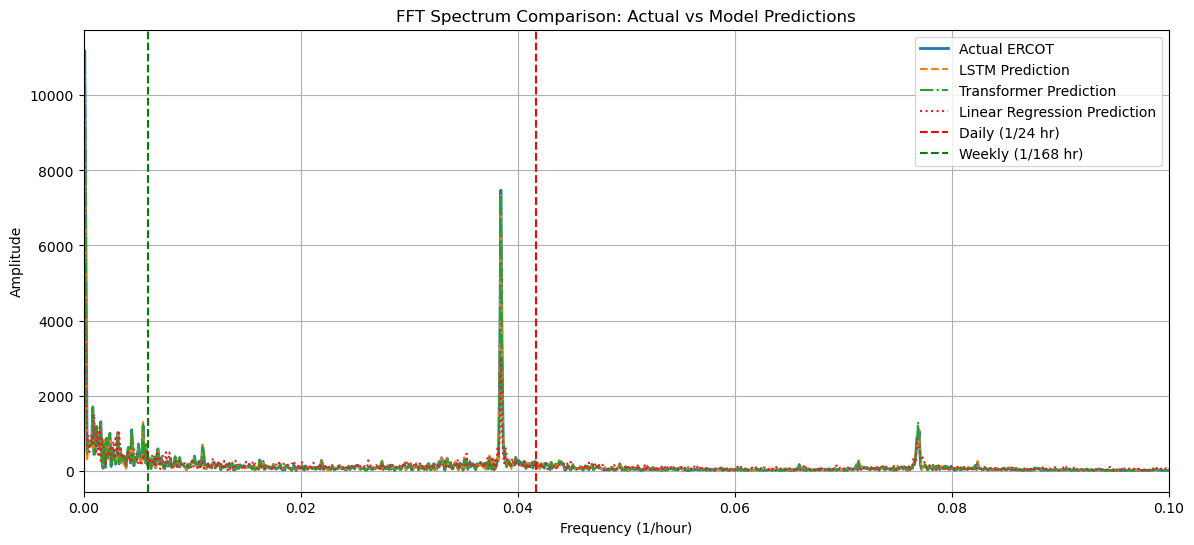

In [110]:
# Compare Spectra of Actual and Model Predictions
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

def compute_fft(series):
    detrended = series - series.mean()
    arr = detrended.to_numpy()
    N = len(arr)
    T = 1  # hourly sampling
    yf = fft(arr)
    xf = np.fft.fftfreq(N, T)[:N//2]
    amplitude = 2.0 / N * np.abs(yf[:N//2])
    return xf, amplitude

# Compute FFT for each series
xf, ercot_fft = compute_fft(df_predictions['ERCOT'])
_, lstm_fft = compute_fft(df_predictions['lstm_pred'])
_, transformer_fft = compute_fft(df_predictions['transformer_pred'])
_, linear_fft = compute_fft(df_predictions['linear_regression_pred'])

# Plot
plt.figure(figsize=(14, 6))
plt.plot(xf, ercot_fft, label='Actual ERCOT', linewidth=2)
plt.plot(xf, lstm_fft, label='LSTM Prediction', linestyle='--')
plt.plot(xf, transformer_fft, label='Transformer Prediction', linestyle='-.')
plt.plot(xf, linear_fft, label='Linear Regression Prediction', linestyle=':')

# Highlight dominant cycles
plt.axvline(1/24, color='red', linestyle='--', label='Daily (1/24 hr)')
plt.axvline(1/(24*7), color='green', linestyle='--', label='Weekly (1/168 hr)')

plt.title('FFT Spectrum Comparison: Actual vs Model Predictions')
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)  # Zoom in on relevant frequencies
plt.show()


In [111]:
import numpy as np
from scipy.fft import fft
from sklearn.metrics import mean_squared_error

def get_fft_amplitude(series):
    detrended = series - series.mean()
    arr = detrended.to_numpy()
    N = len(arr)
    yf = fft(arr)
    amplitude = 2.0 / N * np.abs(yf[:N//2])
    return amplitude

# Get amplitude spectra
ercot_fft = get_fft_amplitude(df_predictions['ERCOT'])
lstm_fft = get_fft_amplitude(df_predictions['lstm_pred'])
transformer_fft = get_fft_amplitude(df_predictions['transformer_pred'])
linear_fft = get_fft_amplitude(df_predictions['linear_regression_pred'])

# Compute RMSEs in frequency domain
def freq_rmse(true_fft, pred_fft):
    return np.sqrt(mean_squared_error(true_fft, pred_fft))

rmse_lstm = freq_rmse(ercot_fft, lstm_fft)
rmse_transformer = freq_rmse(ercot_fft, transformer_fft)
rmse_linear = freq_rmse(ercot_fft, linear_fft)

# Print results
print(f"Frequency-Domain RMSE:")
print(f"  LSTM:         {rmse_lstm:.4f}")
print(f"  Transformer:  {rmse_transformer:.4f}")
print(f"  Linear Reg.:  {rmse_linear:.4f}")


Frequency-Domain RMSE:
  LSTM:         21.8482
  Transformer:  17.0790
  Linear Reg.:  133.8830


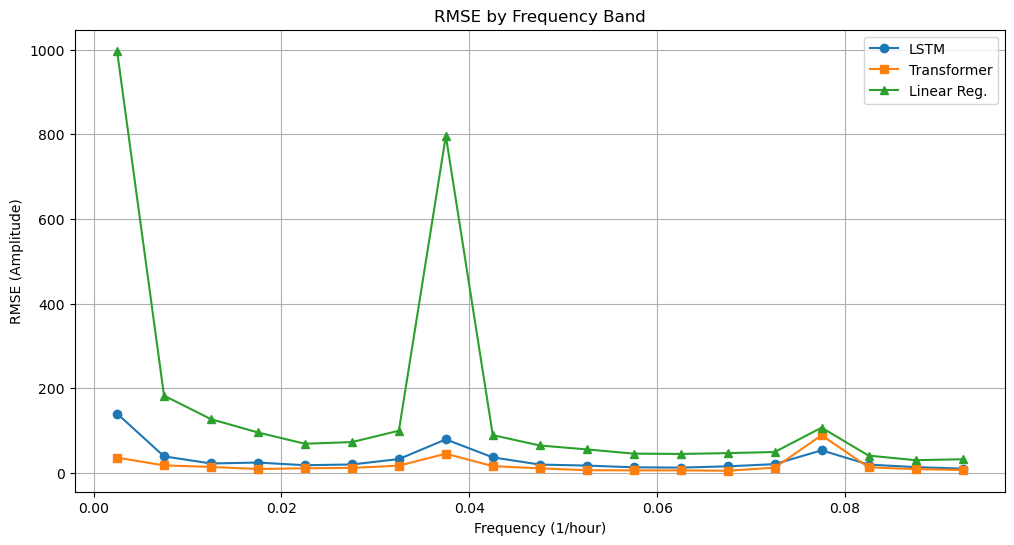

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.metrics import mean_squared_error

def get_fft_freq_amp(series, T=1):
    detrended = series - series.mean()
    arr = detrended.to_numpy()
    N = len(arr)
    yf = fft(arr)
    xf = np.fft.fftfreq(N, T)[:N//2]
    amp = 2.0 / N * np.abs(yf[:N//2])
    return xf, amp

# Get frequency and amplitude for all
xf, ercot_amp = get_fft_freq_amp(df_predictions['ERCOT'])
_, lstm_amp = get_fft_freq_amp(df_predictions['lstm_pred'])
_, transformer_amp = get_fft_freq_amp(df_predictions['transformer_pred'])
_, linear_amp = get_fft_freq_amp(df_predictions['linear_regression_pred'])

# Define frequency bands
band_edges = np.arange(0, 0.1, 0.005)  # Example: bands of width 0.005
band_centers = (band_edges[:-1] + band_edges[1:]) / 2
rmse_lstm = []
rmse_transformer = []
rmse_linear = []

# Compute RMSE for each band
for i in range(len(band_edges) - 1):
    band_mask = (xf >= band_edges[i]) & (xf < band_edges[i+1])
    if band_mask.sum() == 0:
        continue
    rmse_lstm.append(np.sqrt(mean_squared_error(ercot_amp[band_mask], lstm_amp[band_mask])))
    rmse_transformer.append(np.sqrt(mean_squared_error(ercot_amp[band_mask], transformer_amp[band_mask])))
    rmse_linear.append(np.sqrt(mean_squared_error(ercot_amp[band_mask], linear_amp[band_mask])))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(band_centers, rmse_lstm, label='LSTM', marker='o')
plt.plot(band_centers, rmse_transformer, label='Transformer', marker='s')
plt.plot(band_centers, rmse_linear, label='Linear Reg.', marker='^')
plt.title('RMSE by Frequency Band')
plt.xlabel('Frequency (1/hour)')
plt.ylabel('RMSE (Amplitude)')
plt.legend()
plt.grid(True)
plt.show()


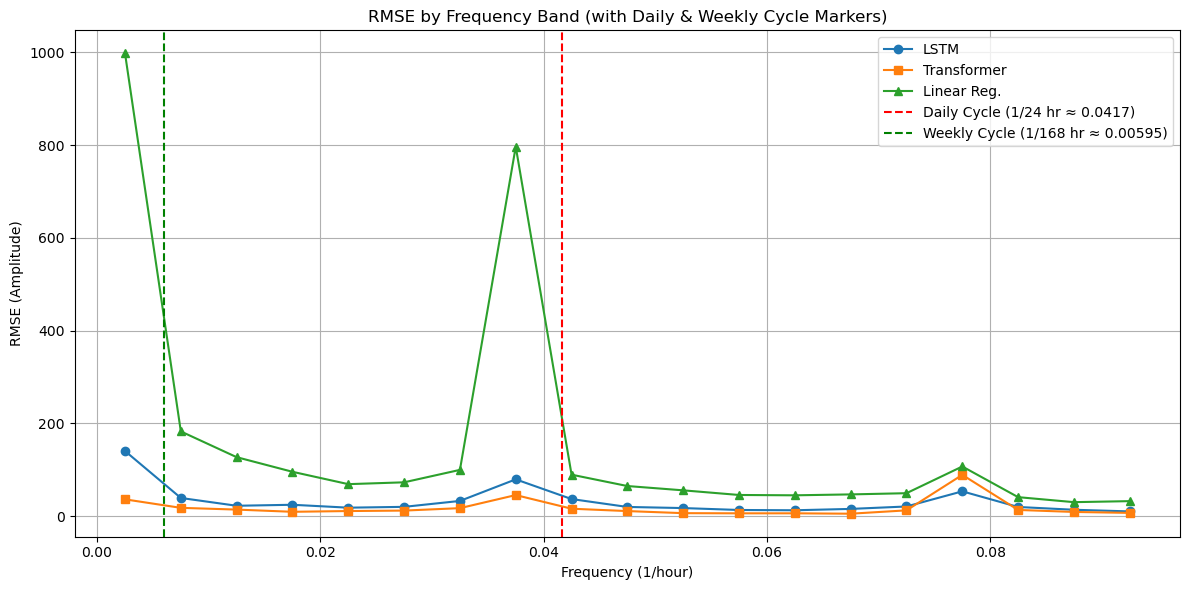

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.metrics import mean_squared_error

def get_fft_freq_amp(series, T=1):
    detrended = series - series.mean()
    arr = detrended.to_numpy()
    N = len(arr)
    yf = fft(arr)
    xf = np.fft.fftfreq(N, T)[:N//2]
    amp = 2.0 / N * np.abs(yf[:N//2])
    return xf, amp

# FFT for all series
xf, ercot_amp = get_fft_freq_amp(df_predictions['ERCOT'])
_, lstm_amp = get_fft_freq_amp(df_predictions['lstm_pred'])
_, transformer_amp = get_fft_freq_amp(df_predictions['transformer_pred'])
_, linear_amp = get_fft_freq_amp(df_predictions['linear_regression_pred'])

# Frequency bands
band_edges = np.arange(0, 0.1, 0.005)
band_centers = (band_edges[:-1] + band_edges[1:]) / 2
rmse_lstm, rmse_transformer, rmse_linear = [], [], []

# RMSE by band
for i in range(len(band_edges) - 1):
    mask = (xf >= band_edges[i]) & (xf < band_edges[i+1])
    if mask.sum() == 0:
        continue
    rmse_lstm.append(np.sqrt(mean_squared_error(ercot_amp[mask], lstm_amp[mask])))
    rmse_transformer.append(np.sqrt(mean_squared_error(ercot_amp[mask], transformer_amp[mask])))
    rmse_linear.append(np.sqrt(mean_squared_error(ercot_amp[mask], linear_amp[mask])))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(band_centers, rmse_lstm, label='LSTM', marker='o')
plt.plot(band_centers, rmse_transformer, label='Transformer', marker='s')
plt.plot(band_centers, rmse_linear, label='Linear Reg.', marker='^')

# Highlight daily and weekly cycle frequencies
plt.axvline(1/24, color='red', linestyle='--', label='Daily Cycle (1/24 hr ≈ 0.0417)')
plt.axvline(1/168, color='green', linestyle='--', label='Weekly Cycle (1/168 hr ≈ 0.00595)')

plt.title('RMSE by Frequency Band (with Daily & Weekly Cycle Markers)')
plt.xlabel('Frequency (1/hour)')
plt.ylabel('RMSE (Amplitude)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


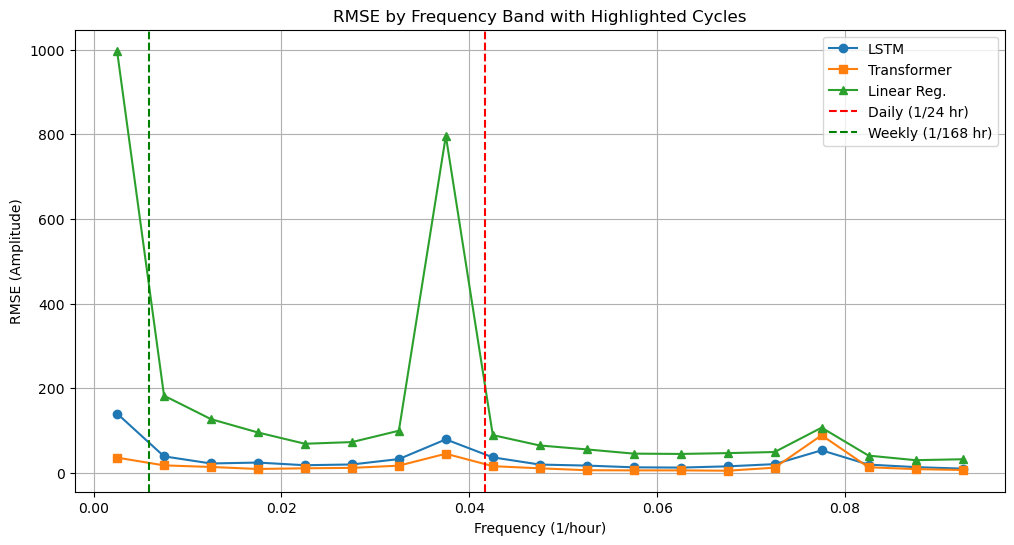

In [114]:
# (Continue from previous code...)

# Plot RMSE by frequency band
plt.figure(figsize=(12, 6))
plt.plot(band_centers, rmse_lstm, label='LSTM', marker='o')
plt.plot(band_centers, rmse_transformer, label='Transformer', marker='s')
plt.plot(band_centers, rmse_linear, label='Linear Reg.', marker='^')

# Highlight dominant cycles
plt.axvline(1/24, color='red', linestyle='--', label='Daily (1/24 hr)')
plt.axvline(1/168, color='green', linestyle='--', label='Weekly (1/168 hr)')

# Labels and display
plt.title('RMSE by Frequency Band with Highlighted Cycles')
plt.xlabel('Frequency (1/hour)')
plt.ylabel('RMSE (Amplitude)')
plt.legend()
plt.grid(True)
plt.show()
